In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Module 11 Lab - Model Evaluation - Solution

**Nota Bene** I don't really expect you to have answered these questions in such detail. I do want to show you what's possible, however.

## Directions

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py

In [4]:
import models

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We'll be working with the insurance data.

**1. Load the data, perform your transformations, and using the Bootstrap version of the Linear Regression function, estimate your final model from Lab 10 and show the Bootstrap results**

Load the data and re-transform the variables that need transforming (categorical variables, age, and BMI):

In [5]:
insurance = pd.read_csv( "insurance.csv", header=0)

In [6]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)
insurance["age_sq"] = insurance.age**2
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

In [7]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1976.96,913.82,3307.78
age_sq,$\beta_{1}$,3.34,3.12,3.53
male,$\beta_{2}$,-423.27,-1100.77,152.10
bmi,$\beta_{3}$,3.32,-32.36,36.42
smoke_yes,$\beta_{4}$,1590.26,-2787.85,4859.76
smoke_yes:bmi,$\beta_{5}$,466.06,345.93,626.10
smoke_yes:bmi_above_30,$\beta_{6}$,15211.86,13844.50,16636.42
children,$\beta_{7}$,695.83,430.99,945.48
male:children,$\beta_{8}$,-85.88,-395.09,320.82


**2. Perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. Using the results for the test data, calculate 95% Bootstrap estimates of the credible intervals for each.** Comment on these intervals and the intervals from above. Are the average values different? Are the intervals different?

First, we're going define some functions to calculate the cross validation. (Note: that you probably can use Scikit Learn's evaluation functions directly. When the course was first started, many of these functions didn't exist.)

This first function "chunks" `xs` into `n` chunks.

In [8]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

This next function does the actual cross validation:

In [9]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Let's run `cross_validation` on our model and data:

In [10]:
formula = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result = cross_validation(models.linear_regression, formula, insurance, lambda r: (r["sigma"], r["r_squared"]))

It's a bit easy to get confused here if you're not sure what you really want. 

In the results above, we have the metric ($\sigma$ or $R^2$) and the 95% credible intervals for the *metric*. Now we have 30 estimates of each metric. That's sufficient to estimate credible bounds. We can just get the quantiles. That is, 3 rounds of 10 fold cross validation is already a kind of Bootstrap estimate of the metric:

In [11]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result], [0.025, 0.975]))

95% CI for sigma: [3108.69661099 5955.28520433]


In [12]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result], [0.025, 0.975]))

95% CI for R^2: [0.72538266 0.93610265]


The *difference* between the two intervals is that the first Bootstrap results are based on a model evaluated against the data it was tested with whereas the 10 fold cross validation simulates the application of the model against data that was not used to train it.

Thus, when we field this model into "production" (use it on new data), the 10 fold cross validation results simulate the range of results we should expect to see (as long as the target population is correct and there is no "concept drift".)

Another possible interpretation of the question is that we can calculate the *mean* $\sigma$ and $R^2$ and calculate the 95% credible intervals for the *mean* values. This also makes sense. If we want to predict the average performance, we might want to see the credible intervals for that *average* performance (yes, we are estimating the average performance of a model that estimates insurance charges).

Let's start by seeing what the mean values are:

In [13]:
sigmas = [r[0] for r in result]
r_squareds = [r[1] for r in result]

In [14]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  4465.483396225769
mean R^2:  0.8641932855492587


In [15]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [16]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [17]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [4236.06196306 4728.74501144]


In [18]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.84803845 0.88317114]


We have fairly tight bounds on what we think the average $\sigma$ and $R^2$ are for our model.

**3. Using Learning Curves and $\sigma$ determine if more data will improve the estimation of the model.**

Here we want to plot ever increasing chunks of the test data to simulate getting more data. This should/may/could also reveal if we are in a high bias or high variance situation.

In [19]:
from collections import defaultdict

In [20]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [21]:
 def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

In [22]:
formula = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result = learning_curves(models.linear_regression, formula, insurance, lambda r: r["sigma"])

In [23]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [24]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

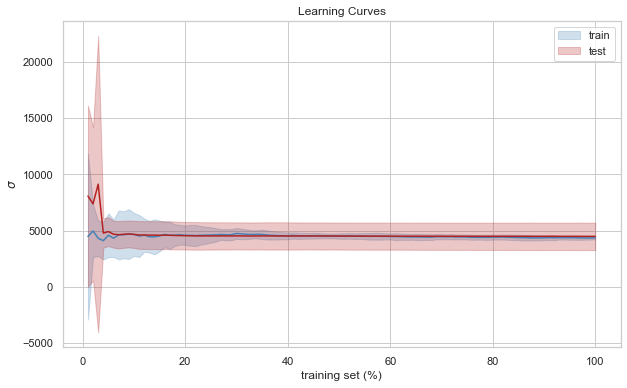

In [25]:
plot_learning_curves(result, r"$\sigma$")

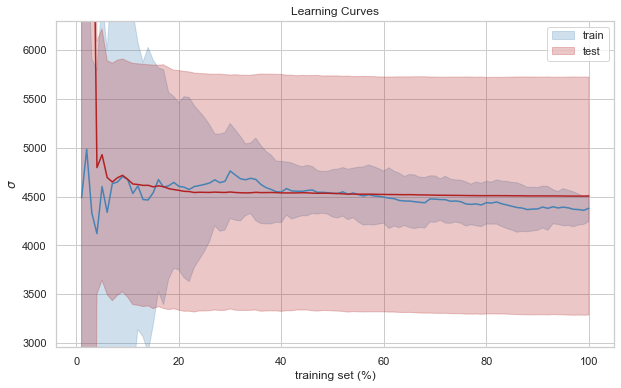

In [26]:
plot_learning_curves(result, r"$\sigma$", zoom=True)

This implementation is based off a submission by a student several semesters ago that I particularly liked. I had to modify it a bit to work with the current `models.py` file.

The description of Learning Curves are kind of under-specified. All most people say is that you need to plot the results for training data and test data. But they tend to be incredibly unstable if you just, say, use just one rotation of your 10 folds (fold 1 for test and folds 2-9 for training then stop).

Once you decide you want to do some averaging, the rest is pretty much up to you. Here we have plotted the  mean and 95.45% intervals.

In this case, it probably doesn't matter. If you look at just the curves (red and blue lines), they've pretty much well converged. Diagnosing "high bias" seems to be somewhat arbitrary. If we can live with the error ($\sigma$), we generally say this is a good model. If we can't ($\sigma$ is too high), then we say this is "high bias". In any case, getting more data won't make the model better.

Learning curves are a tool that gives you guidance...not magic.

**4. It was shown that `age_sq` improved the performance of the model. Perhaps a different polynomial would have been better. Generate Validation Curves for `age_n` ($age^n$) where `n` = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5] and select the best transformation.**

This is admittedly a little bit made up...but, something like this could happen and could make a difference in your model. There's nothing especially magical about $age^2$ and if you needed to fine tune a model, and it looked like it was worth the effort, you might search for a better power.

We'll assume this is true here and do it. Validation curves are essentially the same code as learning curves except that you iterate over the values of the parameter you're changing instead of ever increasing proportions of the test data. We'll be a bit sneaky here so that `formula`, `values`, and `algorithm` are all set up to work together to loop over `values`.

In [27]:
 def validation_curves(algorithm, formulas, data, values, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i, p in enumerate(zip(formulas, values)):
                f, v = p
                # it's ok to resuse the folds for each v of values
                # we calculate the model
                result = algorithm(f, train_data, v)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices(f, train_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices(f, test_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

Making this work for both linear regression and something else is tricky because we might want to vary the formulas and the values for some parameter independently. Oh, well.

In [28]:
values = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]

for v in values:
    insurance["age_" + str(v).replace('.', '_')] = insurance["age"] ** v

In [29]:
formula = "charges ~ male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"

formulas = []
for v in values:
    f = formula + " + age_" + str(v).replace('.', '_')
    formulas.append(f)

def f(formula, data, v):
    return models.linear_regression(formula, data)

result = validation_curves(f, formulas, insurance, values, lambda r: r["sigma"])

In [30]:
def plot_validation_curves( results, metric, parameter, values, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( values, train_mean, color="steelblue")
    axes.fill_between( values, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( values, test_mean, color="firebrick")
    axes.fill_between( values, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( parameter)
    axes.set_ylabel( metric)
    axes.set_title("Validation Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

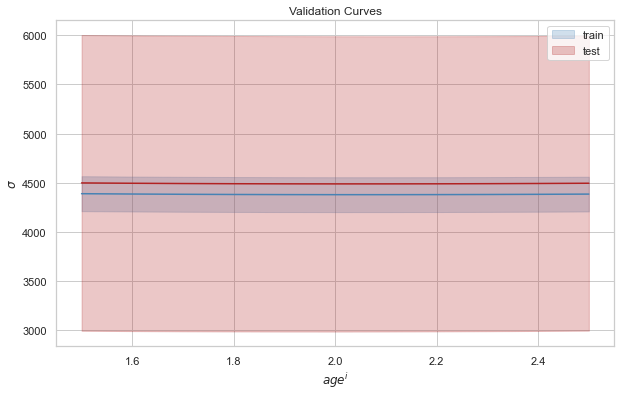

In [31]:
plot_validation_curves(result, r"$\sigma$", r"$age^i$", values)

Maybe we need to look at a larger range of values:

In [32]:
values = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]

for v in values:
    insurance["age_" + str(v).replace('.', '_')] = insurance["age"] ** v

In [33]:
formulas = []
for v in values:
    f = formula + " + age_" + str(v).replace('.', '_')
    formulas.append(f)

def f(formula, data, v):
    return models.linear_regression(formula, data, style="linear")

result = validation_curves(f, formulas, insurance, values, lambda r: r["sigma"])

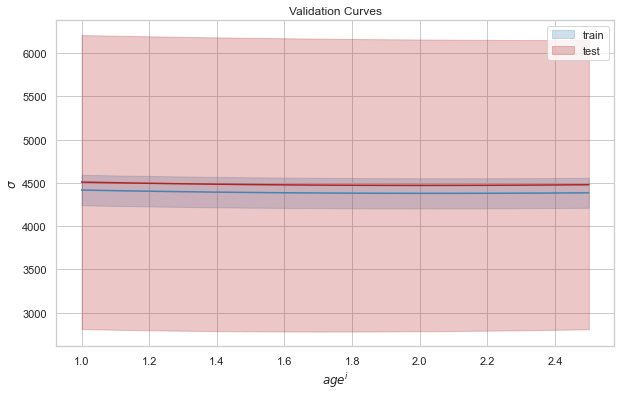

In [34]:
plot_validation_curves(result, r"$\sigma$", r"$age^i$", values)

This is kind of interesting. Here we see the collision of two approaches: looking at residuals and looking at validation curves. 

If you look (very closely) at the curves, these are textbook validation curves. The lowest $\sigma$ on the test set is definitely at 2.1 (we can confirm by printing out the results:)

In [35]:
for v, r in zip(values, result["test"]):
    print(v, result["test"][r])

1.0 (4509.427115244342, 849.9975736233085)
1.1 (4501.984753200402, 850.0457136236824)
1.2 (4495.372495357179, 849.9196076891128)
1.3 (4489.585814426337, 849.6245108587178)
1.4 (4484.6165164179065, 849.1667512586138)
1.5 (4480.4530013898075, 848.5536154081467)
1.6 (4477.080549239267, 847.7932218730791)
1.7 (4474.481623483052, 846.8943870075169)
1.8 (4472.636186196144, 845.8664865106068)
1.9 (4471.522017685373, 844.719316365633)
2.0 (4471.115035034981, 843.462956426988)
2.1 (4471.389604327121, 842.1076395353134)
2.2 (4472.318842078694, 840.6636285818012)
2.3 (4473.874902209457, 839.1411034400828)
2.4 (4476.029245624799, 837.5500591946371)
2.5 (4478.752890243368, 835.9002166006785)


but the intervals say all of this is probably just noise. Given the pattern in the residuals *and* the actual validation curves, I would go with `age_2_1` in my model.

**5. Using Ridge Regression to estimate a model for the insurance data. Compare it with your final Linear Regression model.** (If you get far ahead, you may need to write your own function. Here are the sklearn docs: http://scikit-learn.org/stable/modules/linear_model.html)

This is sort of a trick question. The learning curves show that the current model is *high bias*. When we have high bias, we want to *reduce* regularization, not increase it--at least according to the ML conventional wisdom.

Let's do it anyway. However, this does introduce the annoying requirement that we normalize our data.

In [36]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1338 non-null   int64  
 1   sex           1338 non-null   object 
 2   bmi           1338 non-null   float64
 3   children      1338 non-null   int64  
 4   smoker        1338 non-null   object 
 5   region        1338 non-null   object 
 6   charges       1338 non-null   float64
 7   female        1338 non-null   uint8  
 8   male          1338 non-null   uint8  
 9   northeast     1338 non-null   uint8  
 10  northwest     1338 non-null   uint8  
 11  southeast     1338 non-null   uint8  
 12  southwest     1338 non-null   uint8  
 13  smoke_no      1338 non-null   uint8  
 14  smoke_yes     1338 non-null   uint8  
 15  age_sq        1338 non-null   int64  
 16  bmi_above_30  1338 non-null   int64  
 17  age_1_5       1338 non-null   float64
 18  age_1_6       1338 non-null 

In [37]:
from sklearn.preprocessing import scale

In [38]:
columns = ["charges", "bmi", "age_2_1", "children"]

In [39]:
std_insurance = pd.DataFrame(scale(insurance[columns]), columns=columns)

and then add our dummy variables back in:

In [40]:
t_insurance = pd.concat([std_insurance, insurance[["male", "smoke_yes", "bmi_above_30"]]], axis=1)

We're going to start with a Coefficient Trace to get an idea of how $\alpha$ ($\lambda$) affects this model and data:

In [41]:
n_alphas = 200
alphas = np.logspace(-10, 4, n_alphas)
formula = "charges ~ age_2_1 + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"

coefficients = []
for alpha in alphas:
    result = models.linear_regression(formula, t_insurance, style="ridge", params={"alpha": alpha})
    coefficients.append(result["coefficients"])
coefficients = np.array(coefficients)
coefficients = coefficients.transpose()

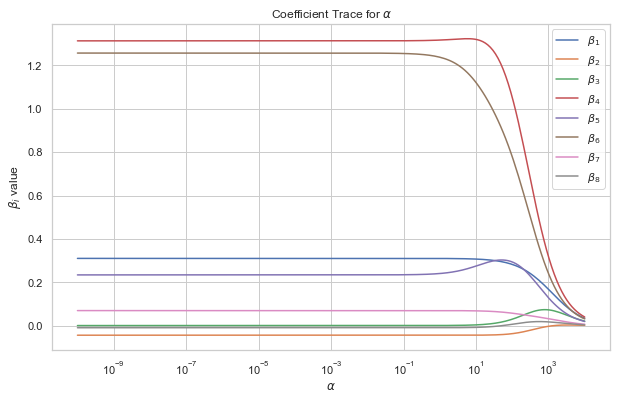

In [42]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

for i in range(1, len(coefficients)):
    axes.plot(alphas, coefficients[i], '-', label=r"$\beta_{0}$".format(i))
axes.legend(loc=1)
axes.set_xscale('log')
axes.set_title( r"Coefficient Trace for $\alpha$")
axes.set_ylabel(r"$\beta_i$ value")
axes.set_xlabel(r"$\alpha$")

plt.show()
plt.close()

The coefficients are stable over incredibly large ranges of $\alpha$. We should probably *not* do any regularization here but let's see what we would happen. We can start at $\alpha=10^{-2}$:

In [43]:
n_alphas = 10
alphas = np.logspace(-2, 2, n_alphas)

formula = "charges ~ age_2_1 + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"

def f(formula, data, v):
    return models.linear_regression(formula, data, style="ridge", params={"alpha": v})

result = validation_curves(f, [formula]*len(alphas), insurance, alphas, lambda r: r["sigma"])

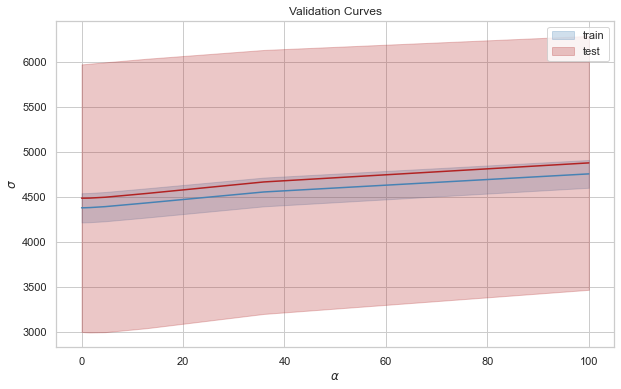

In [44]:
plot_validation_curves(result, r"$\sigma$", r"$\alpha$", alphas)

This is a bit strange.

*If* $\sigma=4500$ is "high error", then the learning curves indicate we are in high bias (it's sometimes difficult to keep these terms straight but you can always derive them from "first principles"). Start with the idea of what "overfitting" must be:

* **high variance** (the easy one) - performance is incredible on the training set but horrible against the test set. Overfitting.
* **high bias** (more difficult) - if the error is "high"/"unacceptable", and performance on the training and test sets is comparable, we are underfitting the data (the representation bias that comes from f() overpowers X).
* **sweet spot** - *looks the same as high bias* except the error is "acceptable".

The last two seem weird because the only difference is if the error is "acceptable" or not. *C'est la vie*.

If we are overfitting, then regularization will help.
If we are underfitting, then regularization won't help.
We seem to be underfitting here.

(I looked at all the data sets we've been working with this semester and none of them were helped by regularization. If someone finds something different, please let me know).